Case Final Quant Fea.dev

Bibliotecas que usaremos

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import backtrader as bt
import itertools


Dados que serão utilizados para teste

In [2]:
dados = yf.download('PETR4.SA', start='2023-01-01', end='2024-01-01', interval='1d')

print(dados.head())


[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2023-01-02  23.540001  23.809999  22.799999  22.920000  15.593499   78424700
2023-01-03  22.940001  23.100000  22.129999  22.340000  15.198902   96750300
2023-01-04  21.959999  23.590000  21.830000  23.049999  15.681944  129504000
2023-01-05  23.340000  24.040001  23.150000  23.879999  16.246634   73886000
2023-01-06  23.940001  24.320000  23.549999  23.740000  16.151382   51851500


Calcularemos agora os índices que são utilizados na Ichimoku Cloud

In [3]:
# Tenkan-sen (Linha de Conversão)
periodo_tenkan = 9
dados['Tenkan_sen'] = (dados['High'].rolling(window=periodo_tenkan).max() + dados['Low'].rolling(window=periodo_tenkan).min()) / 2

# Kijun-sen (Linha de Base)
periodo_kijun = 26
dados['Kijun_sen'] = (dados['High'].rolling(window=periodo_kijun).max() + dados['Low'].rolling(window=periodo_kijun).min()) / 2

# Senkou Span A (Primeira linha da nuvem)
dados['Senkou_span_A'] = ((dados['Tenkan_sen'] + dados['Kijun_sen']) / 2).shift(periodo_kijun)

# Senkou Span B (Segunda linha da nuvem)
periodo_senkou_b = 52
dados['Senkou_span_B'] = ((dados['High'].rolling(window=periodo_senkou_b).max() + dados['Low'].rolling(window=periodo_senkou_b).min()) / 2).shift(periodo_kijun)

# Chikou Span (Linha de Atraso)
dados['Chikou_span'] = dados['Close'].shift(-periodo_kijun)


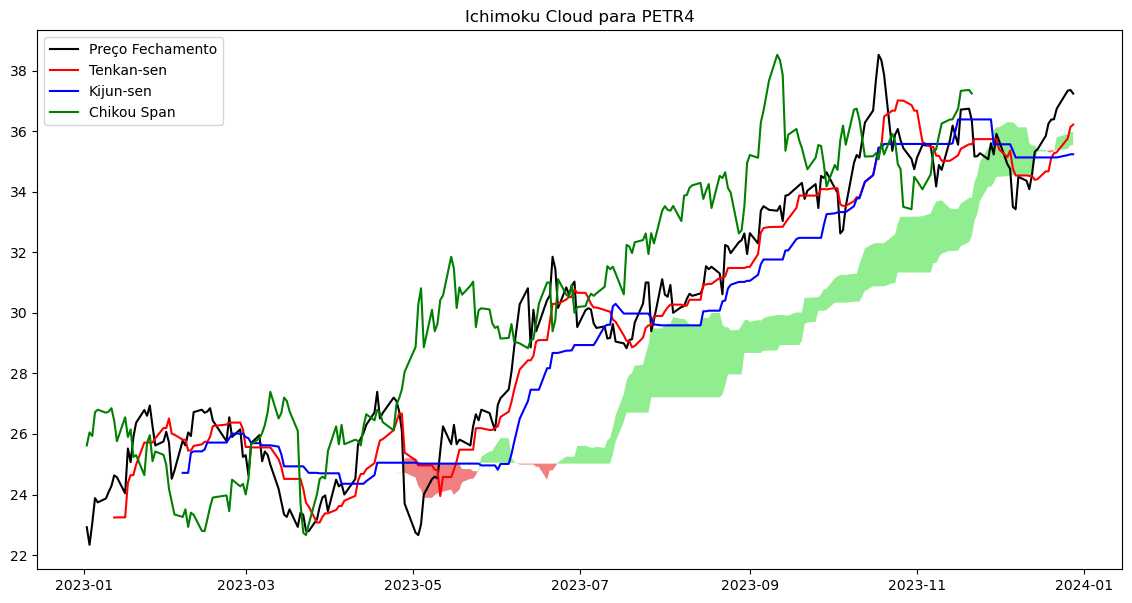

In [4]:
plt.figure(figsize=(14, 7))
plt.plot(dados.index, dados['Close'], label='Preço Fechamento', color='black')
plt.plot(dados.index, dados['Tenkan_sen'], label='Tenkan-sen', color='red')
plt.plot(dados.index, dados['Kijun_sen'], label='Kijun-sen', color='blue')
plt.fill_between(dados.index, dados['Senkou_span_A'], dados['Senkou_span_B'], where=dados['Senkou_span_A'] >= dados['Senkou_span_B'], facecolor='lightgreen', interpolate=True)
plt.fill_between(dados.index, dados['Senkou_span_A'], dados['Senkou_span_B'], where=dados['Senkou_span_A'] < dados['Senkou_span_B'], facecolor='lightcoral', interpolate=True)
plt.plot(dados.index, dados['Chikou_span'], label='Chikou Span', color='green')
plt.legend(loc='best')
plt.title('Ichimoku Cloud para PETR4')
plt.show()


Algoritmo de Trading protótipo.

In [1]:
import backtrader as bt
import yfinance as yf
import pandas as pd
import itertools

class IchimokuStrategy(bt.Strategy):
    params = (
        ('tenkan_period', 9),
        ('kijun_period', 26),
        ('senkou_b_period', 52),
        ('stop_loss', 0.05),  # Stop-loss em 5%
        ('rsi_period', 14),
        ('rsi_upper', 75),    # Ajustando os limites do RSI para tomar mais operações
        ('rsi_lower', 25),
        ('leverage', 2),      # Usando alavancagem de 2:1
    )

    def __init__(self):
        ichimoku = bt.indicators.Ichimoku(
            self.data,
            tenkan=self.params.tenkan_period,
            kijun=self.params.kijun_period,
            senkou=self.params.senkou_b_period
        )

        self.tenkan_sen = ichimoku.tenkan_sen
        self.kijun_sen = ichimoku.kijun_sen
        self.senkou_span_a = ichimoku.senkou_span_a
        self.senkou_span_b = ichimoku.senkou_span_b
        self.chikou_span = ichimoku.chikou_span
        self.order = None

        # Adicionando RSI para evitar sobrecompra/sobrevenda
        self.rsi = bt.indicators.RelativeStrengthIndex(period=self.params.rsi_period)

    def next(self):
        cash_available = self.broker.get_cash()
        
        # Aumentando o trade_size com base na alavancagem definida
        trade_size = (cash_available * self.params.leverage) // self.data.close[0]  # Usando 100% do capital alavancado

        if not self.position:
            # Condições para uma compra
            if (self.data.close > self.senkou_span_a[0] and self.data.close > self.senkou_span_b[0] and 
                self.rsi < self.params.rsi_upper):
                self.order = self.buy(size=trade_size)
            # Condições para uma venda
            elif (self.data.close < self.senkou_span_a[0] and self.data.close < self.senkou_span_b[0] and 
                  self.rsi > self.params.rsi_lower):
                self.order = self.sell(size=trade_size)
        else:
            # Aplicando stop-loss (5%)
            if self.position.size > 0:  # Posição Long
                if (self.data.close < self.senkou_span_a[0] or self.data.close < self.senkou_span_b[0] or 
                    self.data.close < (self.position.price * (1 - self.params.stop_loss))):
                    self.close()
            elif self.position.size < 0:  # Posição Short
                if (self.data.close > self.senkou_span_a[0] or self.data.close > self.senkou_span_b[0] or 
                    self.data.close > (self.position.price * (1 + self.params.stop_loss))):
                    self.close()

def run_backtest(params):
    tenkan_period, kijun_period, senkou_b_period, stop_loss, rsi_period, rsi_upper, rsi_lower = params
    cerebro = bt.Cerebro()
    cerebro.addstrategy(IchimokuStrategy, tenkan_period=tenkan_period, kijun_period=kijun_period, 
                        senkou_b_period=senkou_b_period, stop_loss=stop_loss,
                        rsi_period=rsi_period, rsi_upper=rsi_upper, rsi_lower=rsi_lower)
    
    # Baixar dados históricos da ação a ser utilizada(IMPORTANTE)
    dados = bt.feeds.PandasData(dataname=yf.download('PETR4.SA', start='2023-01-01', end='2024-01-01', interval='1d'))
    cerebro.adddata(dados)
    
    # Configurar alavancagem e comissão
    cerebro.broker.set_cash(100000.0)
    cerebro.broker.setcommission(commission=0.001, leverage=2)  # Alavancagem de 2:1

    cerebro.run()
    return (tenkan_period, kijun_period, senkou_b_period, stop_loss, rsi_period, rsi_upper, rsi_lower, cerebro.broker.getvalue())

def main():
    # Gerar todas as combinações de parâmetros
    param_combinations = list(itertools.product(
        range(7, 11),        # Tenkan-sen
        range(26, 32),       # Kijun-sen
        range(52, 61),       # Senkou B
        [0.01, 0.02, 0.03],  # Stop-loss
        [10, 14, 20],        # RSI período
        [65, 70, 75],        # RSI sobrecompra
        [25, 30, 35]         # RSI sobrevenda
    ))

    # Executar os backtests sequencialmente
    best_result = None
    best_capital = 0

    for params in param_combinations:
        result = run_backtest(params)
        #print(f'Tenkan: {result[0]}, Kijun: {result[1]}, Senkou B: {result[2]}, Stop Loss: {result[3]}, '
        #      f'RSI Período: {result[4]}, RSI Sobrecompra: {result[5]}, RSI Sobrevenda: {result[6]}, '
        #      f'Capital Final: {result[7]}')
        if result[7] > best_capital:
            best_capital = result[7]
            best_result = result

    # Mostrar os melhores parâmetros e o melhor capital final
    if best_result:
        print(f'\nMelhores Parâmetros: Tenkan: {best_result[0]}, Kijun: {best_result[1]}, Senkou B: {best_result[2]}, Stop Loss: {best_result[3]}')
        print(f'RSI Período: {best_result[4]}, RSI Sobrecompra: {best_result[5]}, RSI Sobrevenda: {best_result[6]}')
        print(f'Melhor Capital Final: {best_result[7]}')

main()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******


Melhores Parâmetros: Tenkan: 7, Kijun: 26, Senkou B: 57, Stop Loss: 0.01
RSI Período: 10, RSI Sobrecompra: 65, RSI Sobrevenda: 35
Melhor Capital Final: 96976.2145641327


TESTE